[Reference](https://medium.com/@Eyquem/how-to-predict-stock-volatility-using-garch-model-in-python-df5ba46bae35)

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ticker= "tsla"
tsla_data = yf.download(ticker, start="2018-01-01", end="2022-10-14")

[*********************100%***********************]  1 of 1 completed


In [9]:
tsla_data['Return'] = 100 * (tsla_data['Close'].pct_change())

Text(0.5, 1.0, 'Daily Returns Over Time')

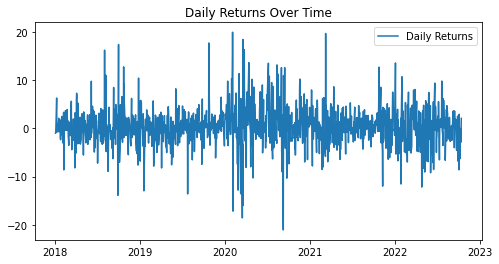

In [10]:
tsla_data.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
# ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

In [11]:
daily_volatility = tsla_data['Return'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility

from tabulate import tabulate

print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         4.11         │         18.83          │         65.22         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


In [13]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.3 MB/s 


In [17]:
from arch import arch_model
from arch.__future__ import reindexing

garch_model = arch_model(tsla_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu          0.252721
omega       0.902331
alpha[1]    0.071748
beta[1]     0.873923
Name: params, dtype: float64


                                 h.1        h.2        h.3        h.4  \
Date                                                                    
2022-10-13 00:00:00-04:00  14.218493  14.348346  14.471145  14.587273   

                                 h.5  
Date                                  
2022-10-13 00:00:00-04:00  14.697091  


Text(0.5, 1.0, 'Rolling Prediction')

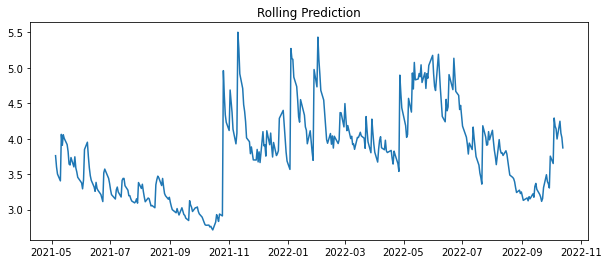

In [21]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = tsla_data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=tsla_data['Return'].index[-365:])

fig,ax = plt.subplots(figsize=(10,4))
# ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

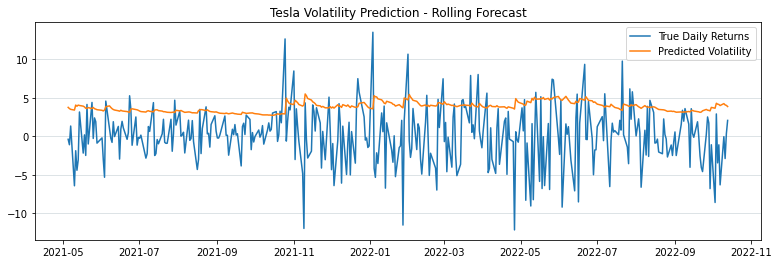

In [22]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
# ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Tesla Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])